In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import lsst.afw.display.rgb as rgb
from scipy import interpolate

from astropy.table import Table
import matplotlib
import matplotlib.mlab as mlab
import numpy as np

import lsst.afw.display as afwDisplay
from python.simulation_utils import simulation_wrapper, OpSim_wrapper
from python.notebook_utils import look, get_xkcd_color, load_diffim, plot_diffim_quiver, dcr_metric
import lsst.daf.persistence as daf_persistence
from lsst.ip.diffim.dcrModel import calculateDcr

In [2]:
base_dir = "/Users/sullivan/LSST/simulations/OpSim/"

OpSim baseline2018a

In [7]:
opsim_version = "pontus_2568/"

In [8]:
varPSF_run = "mosaic_42_varPSF_rand/"

In [9]:
dcr_rerun_base = "input_data/rerun/processed_data/rerun/seeing_dcr_"
deep_rerun_base = "input_data/rerun/processed_data/rerun/seeing_cw_"

In [5]:
def extract_dcr(field_table, fieldId):
    fields = set(field_table["fieldId"])
    if fieldId not in fields:
        print('ValueError("fieldId not found in table")')
    rows = field_table["fieldId"] == fieldId
    dcr = field_table["dcr"].data[rows]
    return dcr

In [28]:
seeing_id = 1
visits_alerts = [[2000000, 2000023]]

In [34]:
template_deep = {}
alerts_deep = {}
template_dcr = {}
alerts_dcr = {}
for seeing_id in range(1, 9):
    seeing_name = "%i/" % seeing_id
    visits_template = [[1010000 + (seeing_id - 1)*100, 1010007 + (seeing_id - 1)*100]]
    template_deep0, alerts_deep0 = load_diffim(base_dir + opsim_version + varPSF_run,
                                               deep_rerun_base + seeing_name, dcr_rerun_base + seeing_name,
                                               visits_template, visits_alerts,
                                               filter_name='g', coaddName='deep')
    template_deep[seeing_id] = template_deep0
    alerts_deep[seeing_id] = alerts_deep0
    template_dcr0, alerts_dcr0 = load_diffim(base_dir + opsim_version + varPSF_run,
                                             deep_rerun_base + seeing_name, dcr_rerun_base + seeing_name,
                                             visits_template, visits_alerts,
                                             filter_name='g', coaddName='dcr')
    template_dcr[seeing_id] = template_dcr0
    alerts_dcr[seeing_id] = alerts_dcr0

Skipping 2000021, no data.
Skipping 2000021, no data.
Skipping 2000021, no data.
Skipping 2000021, no data.
Skipping 2000021, no data.
Skipping 2000021, no data.
Skipping 2000021, no data.
Skipping 2000021, no data.
Skipping 2000021, no data.
Skipping 2000021, no data.
Skipping 2000021, no data.
Skipping 2000021, no data.
Skipping 2000021, no data.
Skipping 2000021, no data.
Skipping 2000021, no data.
Skipping 2000021, no data.


In [38]:
template_dcr[1]

fieldId,year,visit,airmass,parAng,dcr [2]
str4,int64,int64,float64,float64,float64
0100,1,1010000,1.19475683432965,179.99999999999994,-0.8282768724965857 .. 8.37092305759252e-16
0100,1,1010001,1.24658743788867,0.0,0.943075041017214 .. 0.0
0100,1,1010002,1.46729693009773,0.0,1.36146046252252 .. 0.0
0100,1,1010003,1.01115649428996,0.0,0.189679605078548 .. 0.0
0100,1,1010004,1.14309549684841,0.0,0.7014705616415529 .. 0.0
0100,1,1010005,1.05022161946558,0.0,0.4063682714571246 .. 0.0
0100,1,1010006,1.03895171870239,0.0,0.35688562953180564 .. 0.0
0100,1,1010007,1.04729503388819,179.99999999999994,-0.39406598892784866 .. 3.982600725028363e-16


In [46]:
test = template_dcr[3]
test['fieldId'] == '0100'

array([False, False, False, False, False, False, False, False])

In [47]:
metrics = {}
for seeing_id in range(1, 9):
    metric = dcr_metric(template_dcr[seeing_id], '010%i' % (seeing_id - 1))
    metrics[seeing_id] = metric
print(metrics)

{1: 7.463093534506346, 2: 7.463093534506346, 3: 7.463093534506346, 4: 7.463093534506346, 5: 7.463093534506346, 6: 7.463093534506346, 7: 7.463093534506346, 8: 7.463093534506346}


<IPython.core.display.Javascript object>


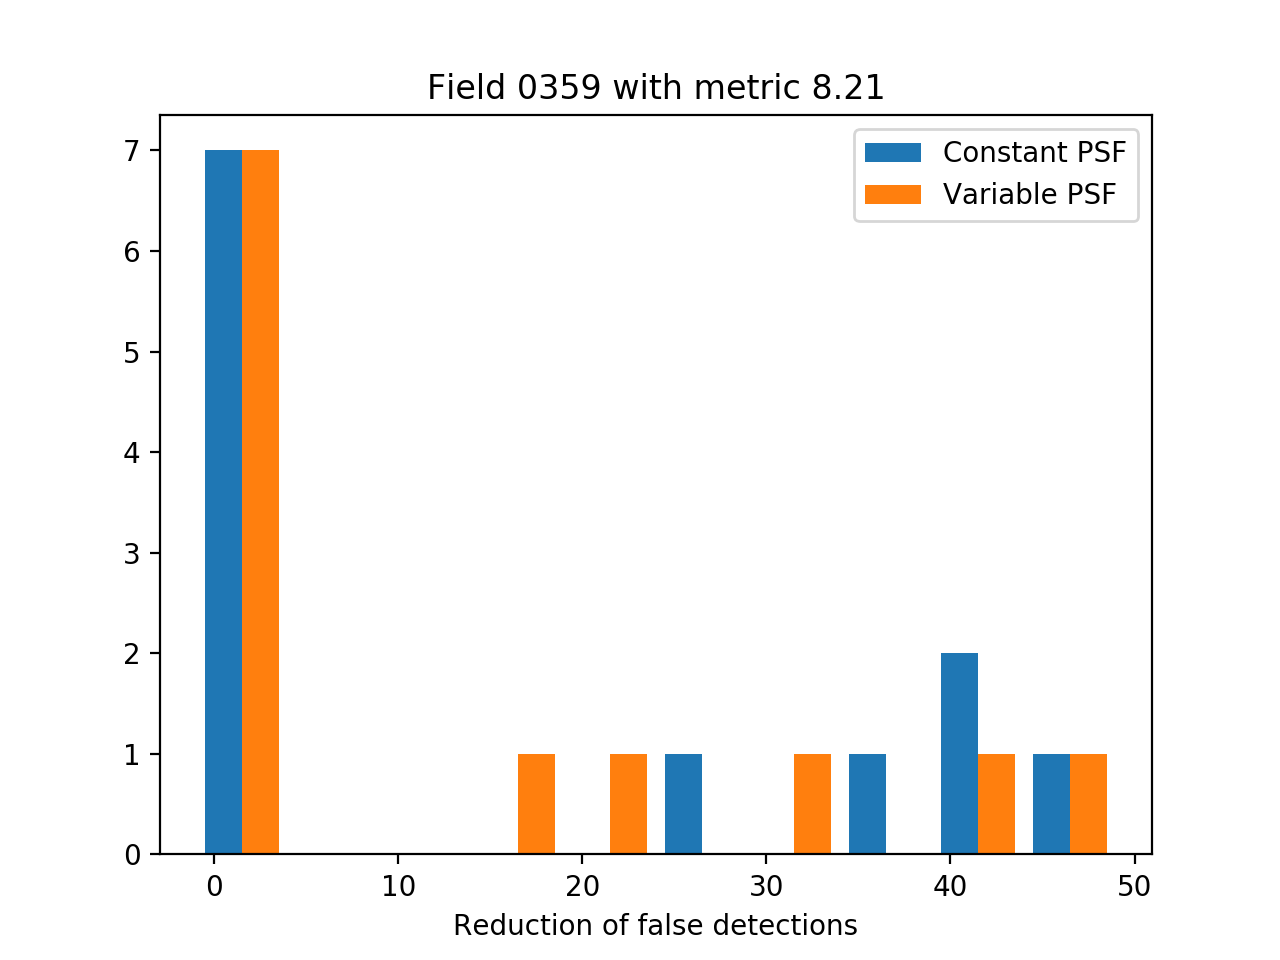

In [22]:
field = '0359'
deep_const = const_alerts_deep["nDipole"][const_alerts_deep["fieldId"] == field]
dcr_const = const_alerts_dcr["nDipole"][const_alerts_dcr["fieldId"] == field]
deep_var = var_alerts_deep["nDipole"][var_alerts_deep["fieldId"] == field]
dcr_var = var_alerts_dcr["nDipole"][var_alerts_dcr["fieldId"] == field]
plt.hist([deep_const - dcr_const, deep_var - dcr_var], histtype='bar')
plt.title("Field %s with metric %4.2f" % (field, metrics[field]))
plt.xlabel('Reduction of false detections')
plt.legend(["Constant PSF", "Variable PSF"])

In [48]:
def plot_diffim_quiver(deep_constPSF, dcr_constPSF, deep_varPSF, dcr_varPSF,
                       quantity="nDipole", window=1, **kwargs):
    field_list = list(set(deep_constPSF["fieldId"]))
    afwDisplay.Display(window)
    color_gen = get_xkcd_color()
    names = []
    for field in field_list:
        const_metric = dcr_metric(dcr_constPSF, field, binsize=0.05)
        var_metric = dcr_metric(dcr_varPSF, field, binsize=0.05)
        names.append("Field %s with metrics const:%4.2f var:%4.2f" % (field, const_metric, var_metric))
        q1a = deep_constPSF[quantity][deep_constPSF["fieldId"] == field]
        q2a = dcr_constPSF[quantity][dcr_constPSF["fieldId"] == field]
        q1b = deep_varPSF[quantity][deep_varPSF["fieldId"] == field]
        q2b = dcr_varPSF[quantity][dcr_varPSF["fieldId"] == field]
        x = q1a
        y = q1b
        dx = q2a - q1a
        dy = q2b - q1b
        c = 'xkcd:' + next(color_gen)
        plt.quiver(x, y, dx, dy, color=c, angles='xy', scale_units='xy', scale=1., **kwargs)
    plt.xlabel('False detections using constant PSF (deep -> dcr)')
    plt.ylabel('False detections using variable PSF with good seeing cut')
    plt.legend(names)

In [82]:
seeing_range = {}
seeing = 1.0
for seeing_id in range(1,9):
    seeing_range[seeing_id] = (seeing - 1)*100
    seeing *= 1.1

In [96]:
print("Seeing range \t deep \t dcr")
for seeing_id in range(1, 9):
    print("\t%2.0f%%: \t%4.2f\t%4.2f" % (seeing_range[seeing_id],
                                       np.mean(alerts_deep[seeing_id]["nDipole"]),
                                       np.mean(alerts_dcr[seeing_id]["nDipole"])))

Seeing range 	 deep 	 dcr
	 0%: 	16.96	2.57
	10%: 	17.43	2.61
	21%: 	17.17	3.30
	33%: 	19.04	4.52
	46%: 	19.13	4.22
	61%: 	19.35	4.17
	77%: 	20.48	4.13
	95%: 	23.17	4.52


In [56]:
def plot_diffim_quiver(deep_table, dcr_table, template=None,
                       quantity="nDipole", window=1, psf_name='constant',
                       legend_location=4, metric_max=12., seeing_dict=None, **kwargs):
    field_list = list(set(deep_table["fieldId"]))
    afwDisplay.Display(window)
    names = []
    cmap = plt.get_cmap("plasma")
    plotQ = plt.figure(window)
    for field in field_list:
        names.append("Field %s" % field)
        q1 = deep_table[quantity][deep_table["fieldId"] == field]
        q2 = dcr_table[quantity][dcr_table["fieldId"] == field]
        airmass = np.array(deep_table["airmass"][deep_table["fieldId"] == field])
        if seeing_dict is not None:
            visits = deep_table["visit"][deep_table["fieldId"] == field]
            seeing = [seeing_dict[visit] for visit in visits]
        else:
            seeing = np.zeros(len(airmass)) + .7
        parAng = np.array(deep_table["parAng"][deep_table["fieldId"] == field])
        x = q1
        y = airmass
        dx = q2 - q1
        dy = np.zeros(len(y))
        M = seeing
        plt.quiver(x, y, dx, dy, seeing, angles='xy', scale_units='xy', scale=1.,
                   cmap=plt.get_cmap('viridis'), **kwargs)
#     plt.yscale("linear", subsy=np.arange(1, 2, .1))
    plt.grid(True)
    plt.xlabel('False detections using %s PSF (deep -> dcr)' % psf_name)
    plt.ylabel('Airmass')
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('Seeing (arcsec)')
    plt.clim(0.5, 2.0)
#     plt.legend(names, loc=legend_location)

<IPython.core.display.Javascript object>


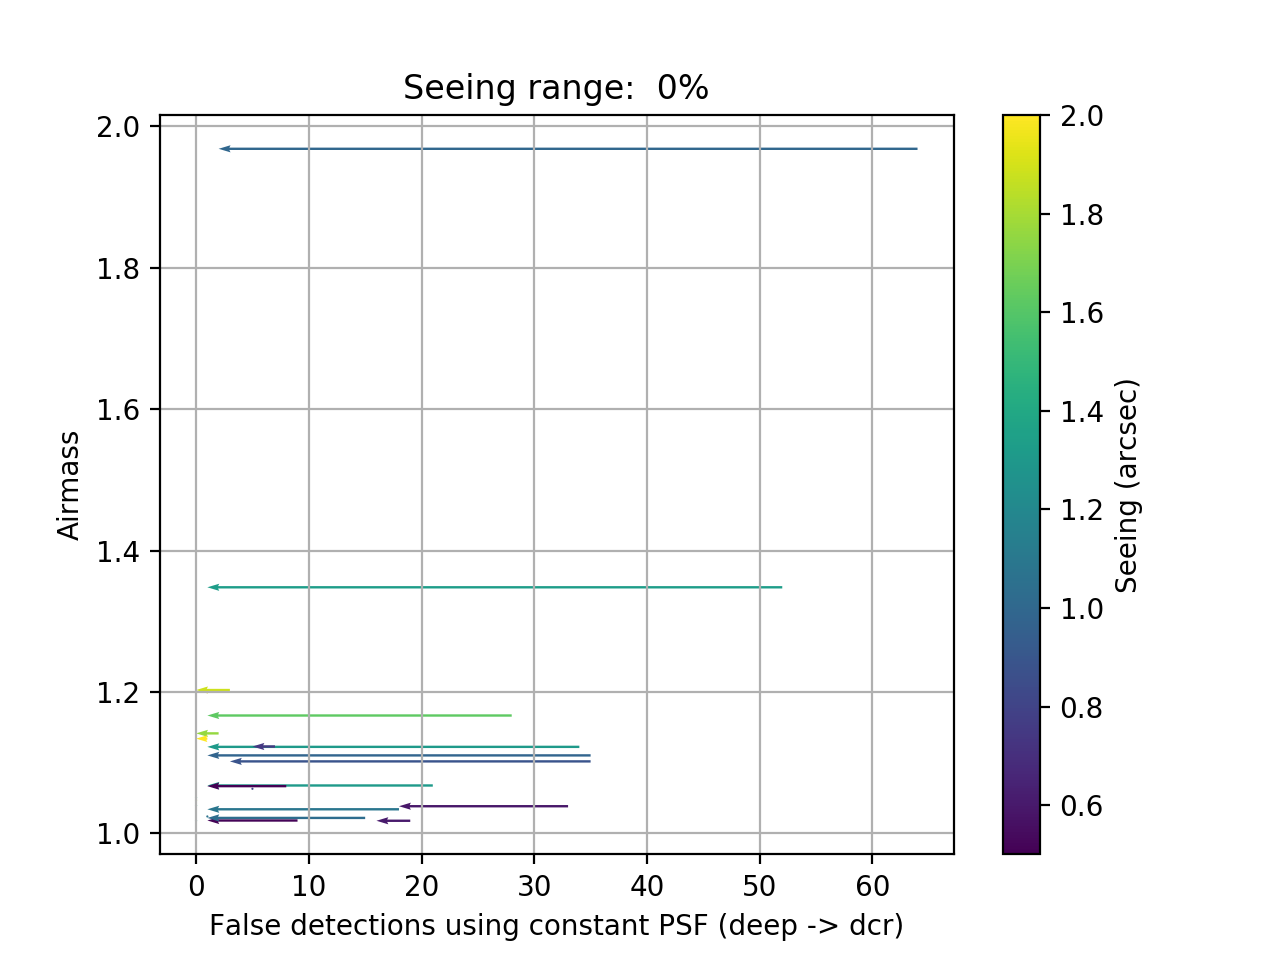

Text(0.5,1,'Seeing range:  0%')

In [83]:
seeing_id = 1
plot_diffim_quiver(alerts_deep[seeing_id], alerts_dcr[seeing_id],
                   psf_name='constant', window=3, width=3e-3, seeing_dict=seeing_dict)
plt.title("Seeing range: %2.0f%%" % seeing_range[seeing_id])

<IPython.core.display.Javascript object>


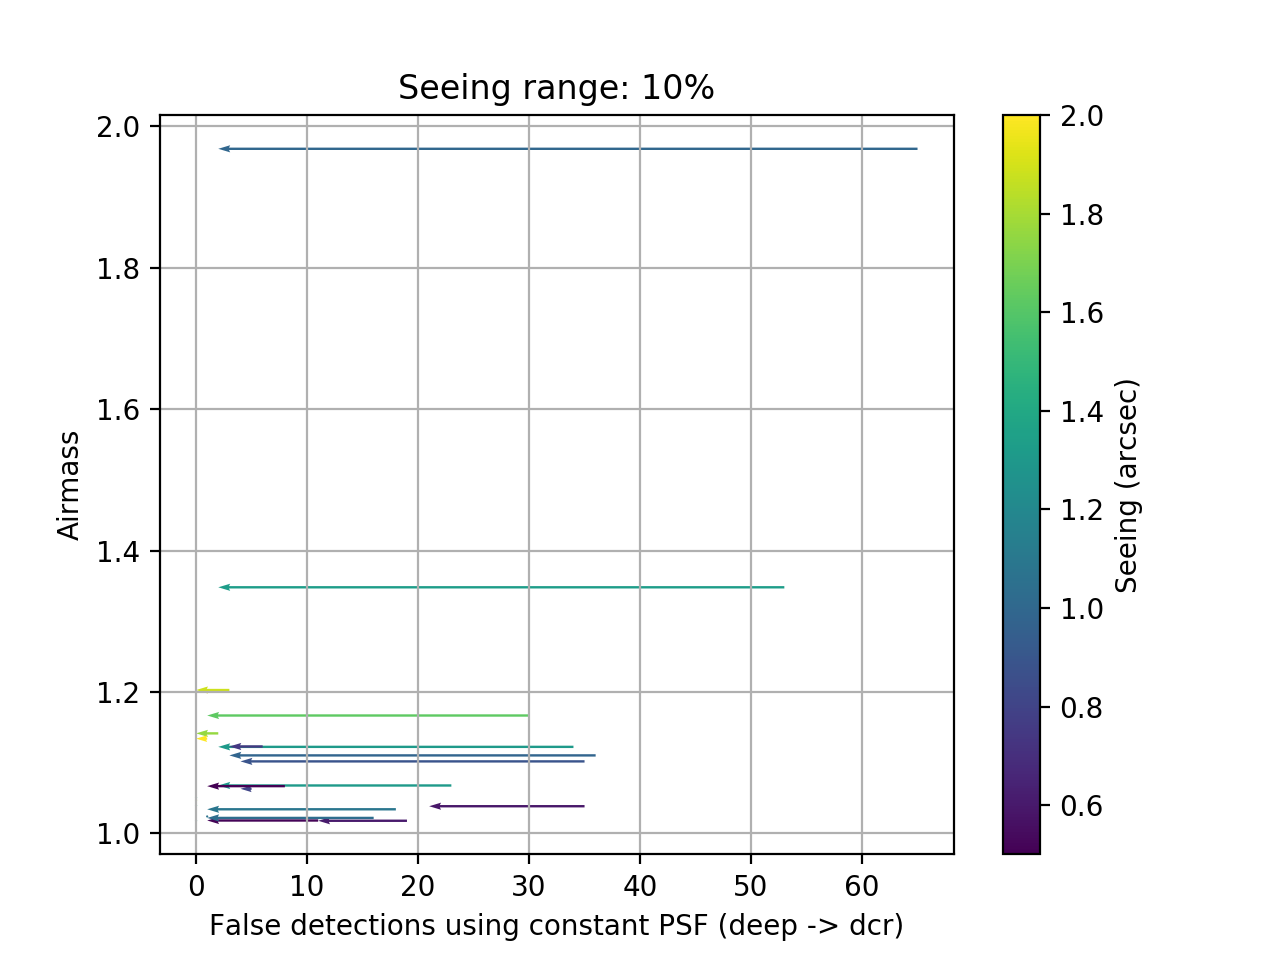

Text(0.5,1,'Seeing range: 10%')

In [84]:
seeing_id = 2
plot_diffim_quiver(alerts_deep[seeing_id], alerts_dcr[seeing_id],
                   psf_name='constant', window=3, width=3e-3, seeing_dict=seeing_dict)
plt.title("Seeing range: %2.0f%%" % seeing_range[seeing_id])

<IPython.core.display.Javascript object>


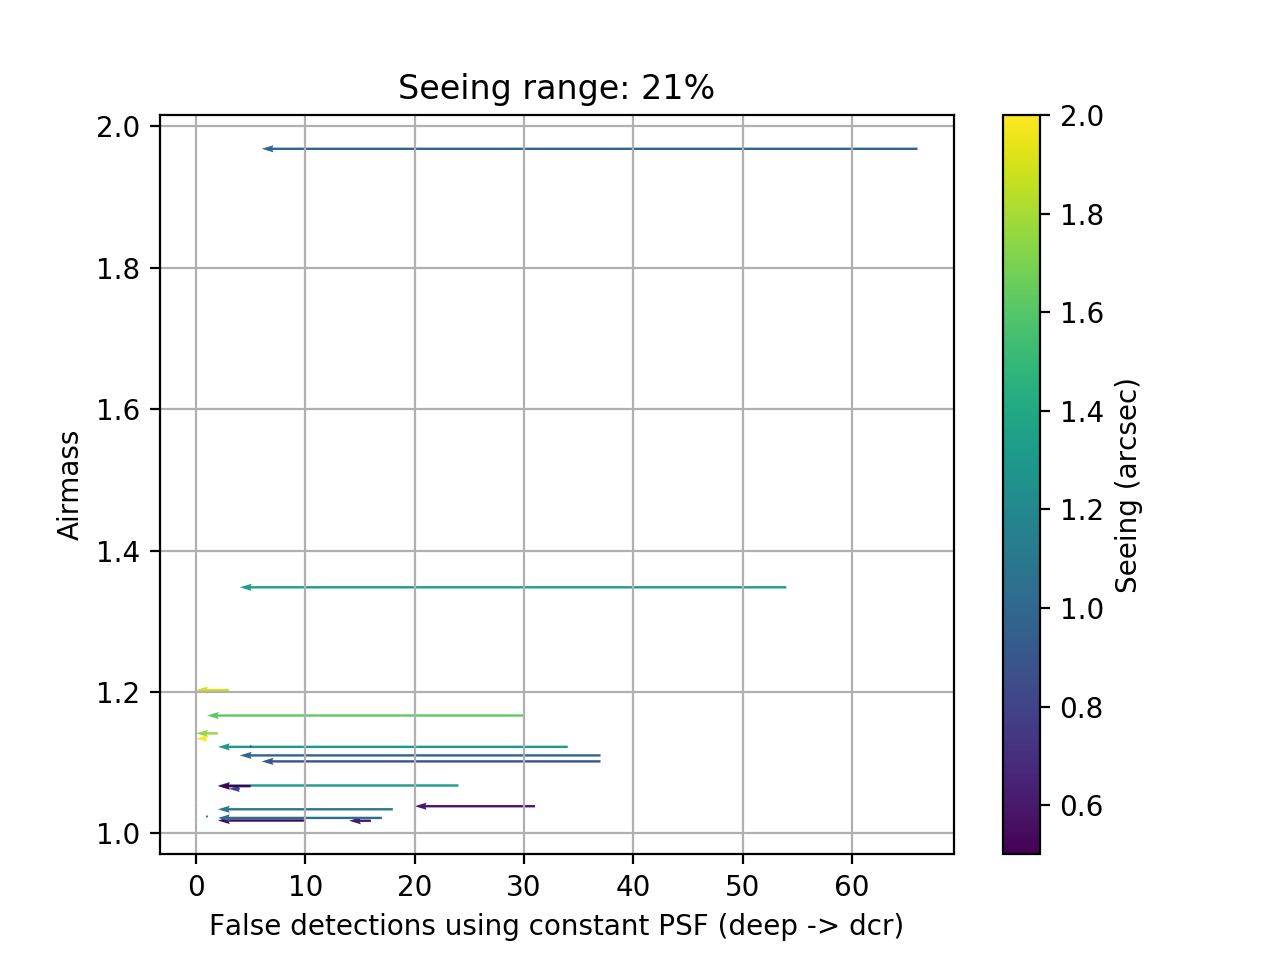

Text(0.5,1,'Seeing range: 21%')

In [85]:
seeing_id = 3
plot_diffim_quiver(alerts_deep[seeing_id], alerts_dcr[seeing_id],
                   psf_name='constant', window=3, width=3e-3, seeing_dict=seeing_dict)
plt.title("Seeing range: %2.0f%%" % seeing_range[seeing_id])

<IPython.core.display.Javascript object>


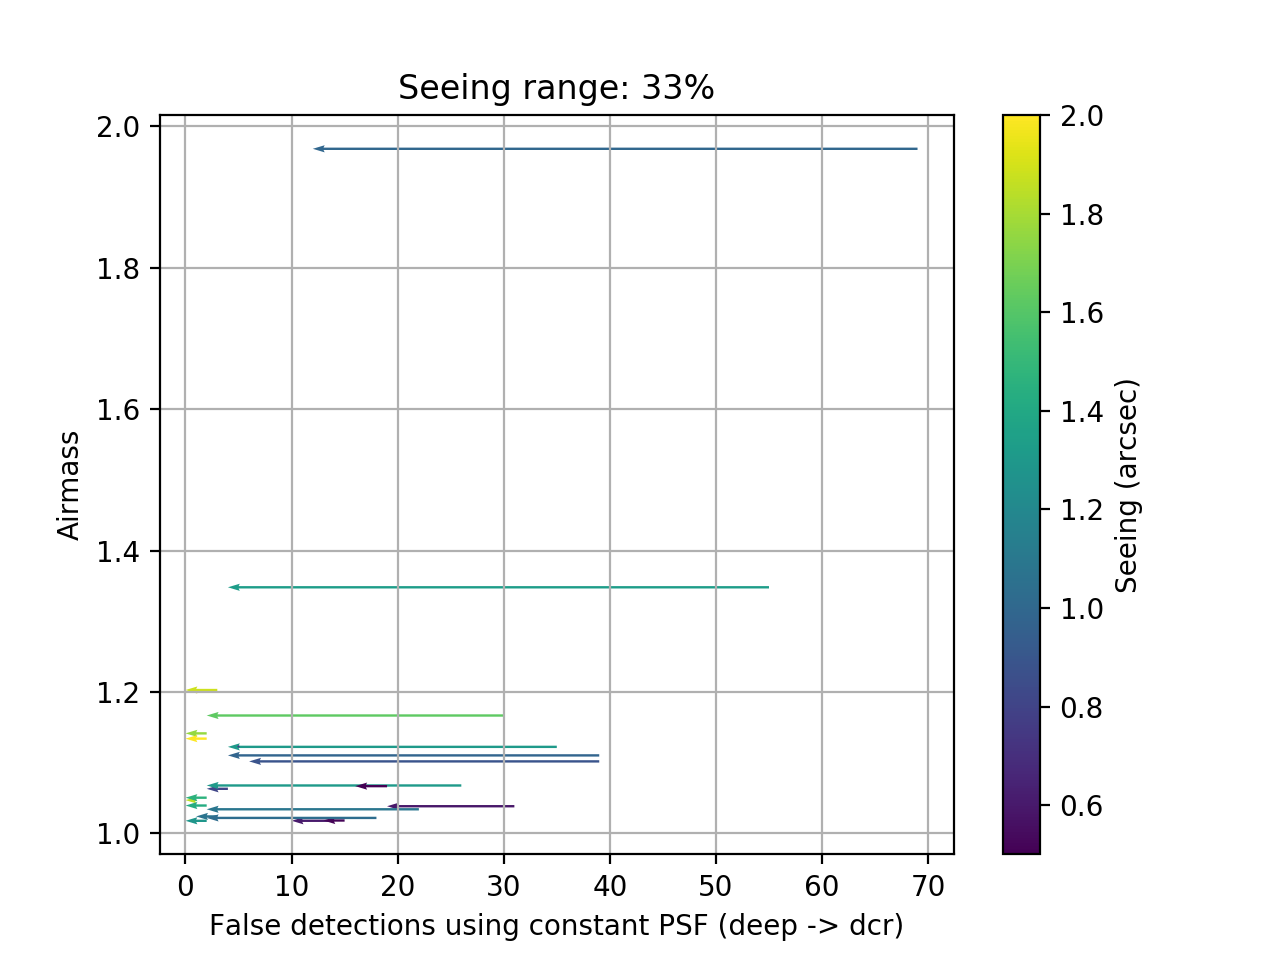

Text(0.5,1,'Seeing range: 33%')

In [86]:
seeing_id = 4
plot_diffim_quiver(alerts_deep[seeing_id], alerts_dcr[seeing_id],
                   psf_name='constant', window=3, width=3e-3, seeing_dict=seeing_dict)
plt.title("Seeing range: %2.0f%%" % seeing_range[seeing_id])

<IPython.core.display.Javascript object>


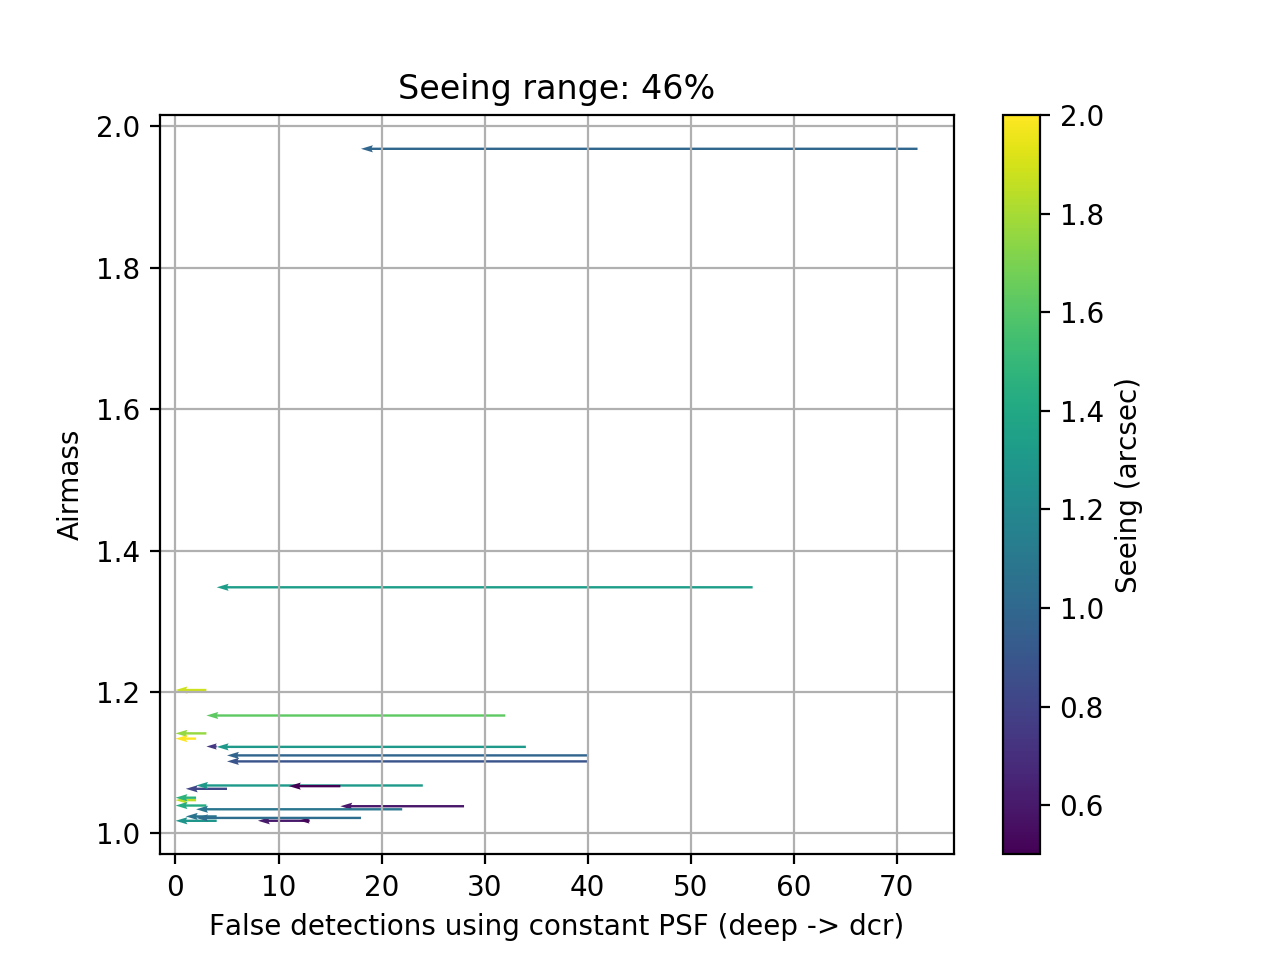

Text(0.5,1,'Seeing range: 46%')

In [87]:
seeing_id = 5
plot_diffim_quiver(alerts_deep[seeing_id], alerts_dcr[seeing_id],
                   psf_name='constant', window=3, width=3e-3, seeing_dict=seeing_dict)
plt.title("Seeing range: %2.0f%%" % seeing_range[seeing_id])

<IPython.core.display.Javascript object>


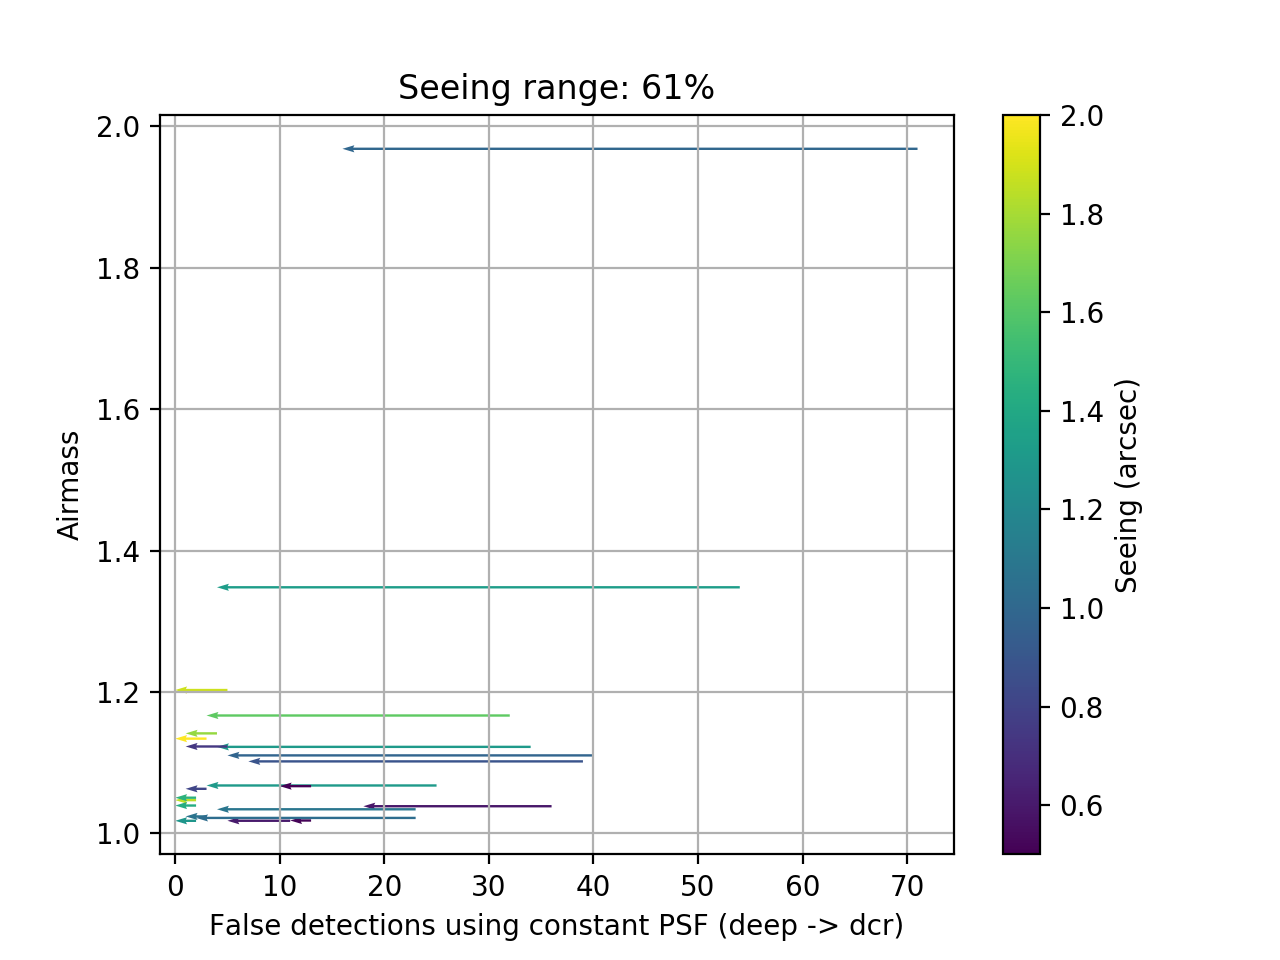

Text(0.5,1,'Seeing range: 61%')

In [88]:
seeing_id = 6
plot_diffim_quiver(alerts_deep[seeing_id], alerts_dcr[seeing_id],
                   psf_name='constant', window=3, width=3e-3, seeing_dict=seeing_dict)
plt.title("Seeing range: %2.0f%%" % seeing_range[seeing_id])

<IPython.core.display.Javascript object>


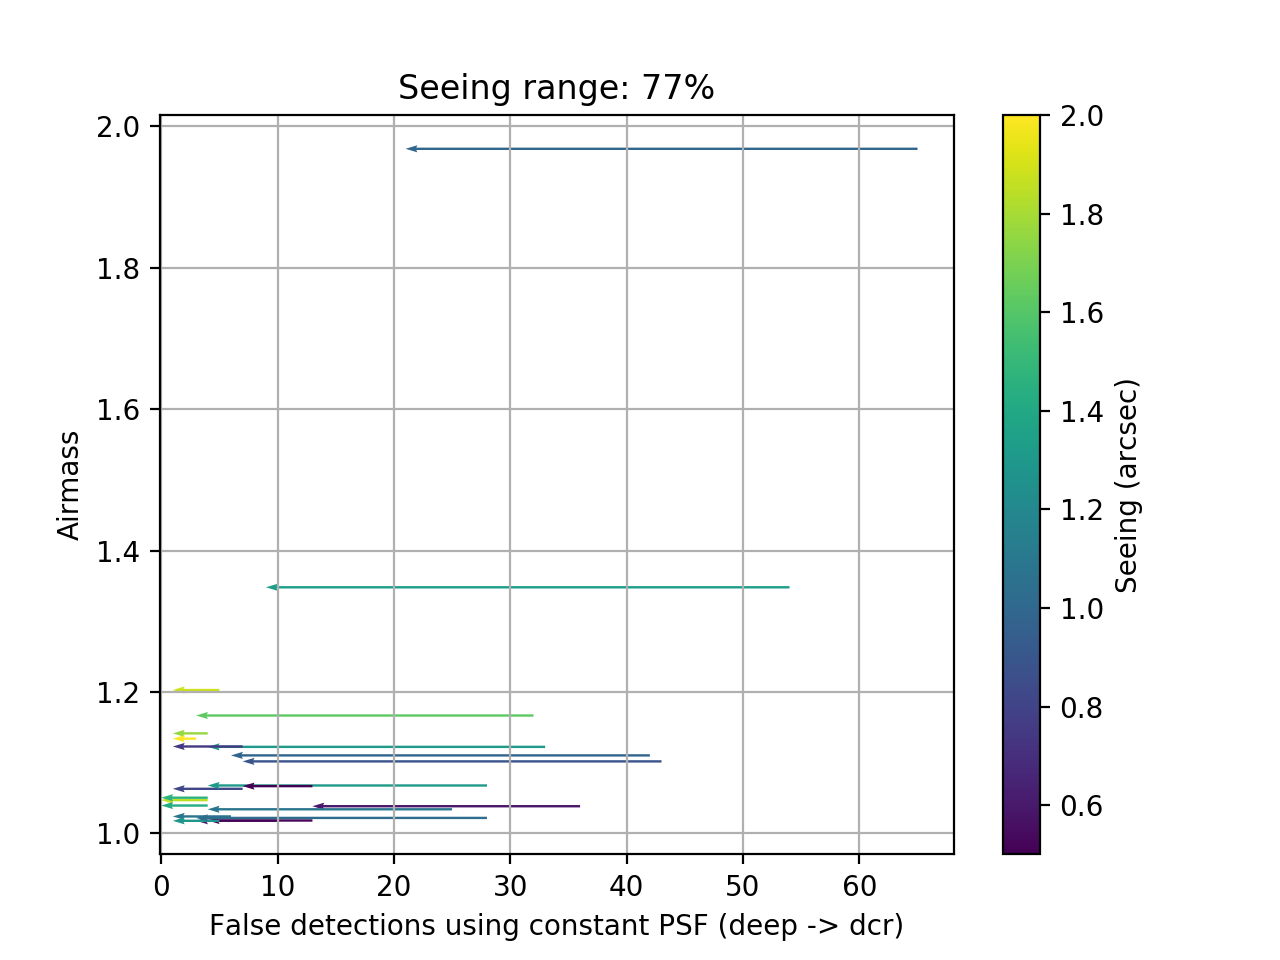

Text(0.5,1,'Seeing range: 77%')

In [89]:
seeing_id = 7
plot_diffim_quiver(alerts_deep[seeing_id], alerts_dcr[seeing_id],
                   psf_name='constant', window=3, width=3e-3, seeing_dict=seeing_dict)
plt.title("Seeing range: %2.0f%%" % seeing_range[seeing_id])

<IPython.core.display.Javascript object>


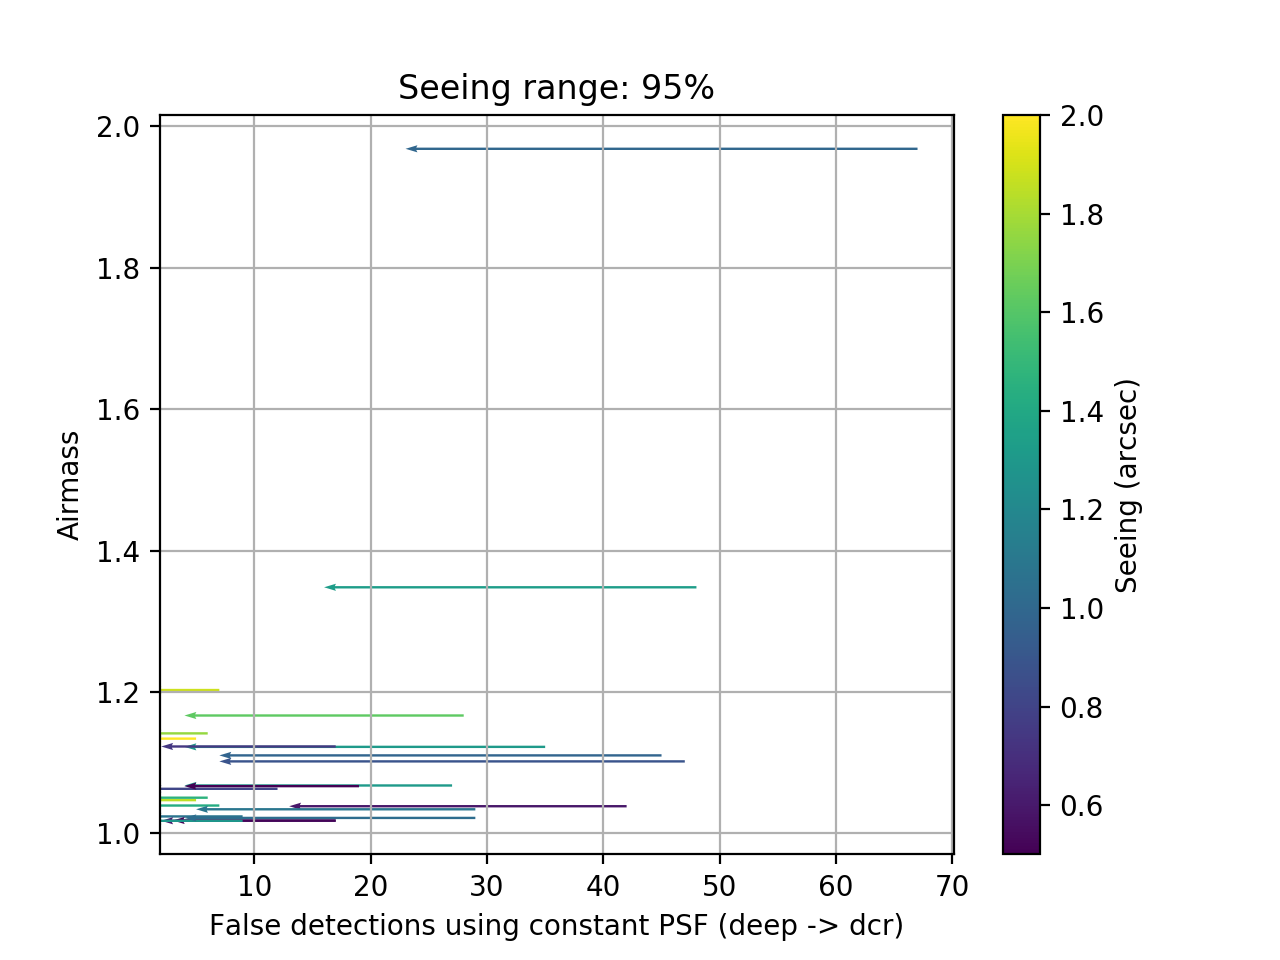

Text(0.5,1,'Seeing range: 95%')

In [90]:
seeing_id = 8
plot_diffim_quiver(alerts_deep[seeing_id], alerts_dcr[seeing_id],
                   psf_name='constant', window=3, width=3e-3, seeing_dict=seeing_dict)
plt.title("Seeing range: %2.0f%%" % seeing_range[seeing_id])

<IPython.core.display.Javascript object>


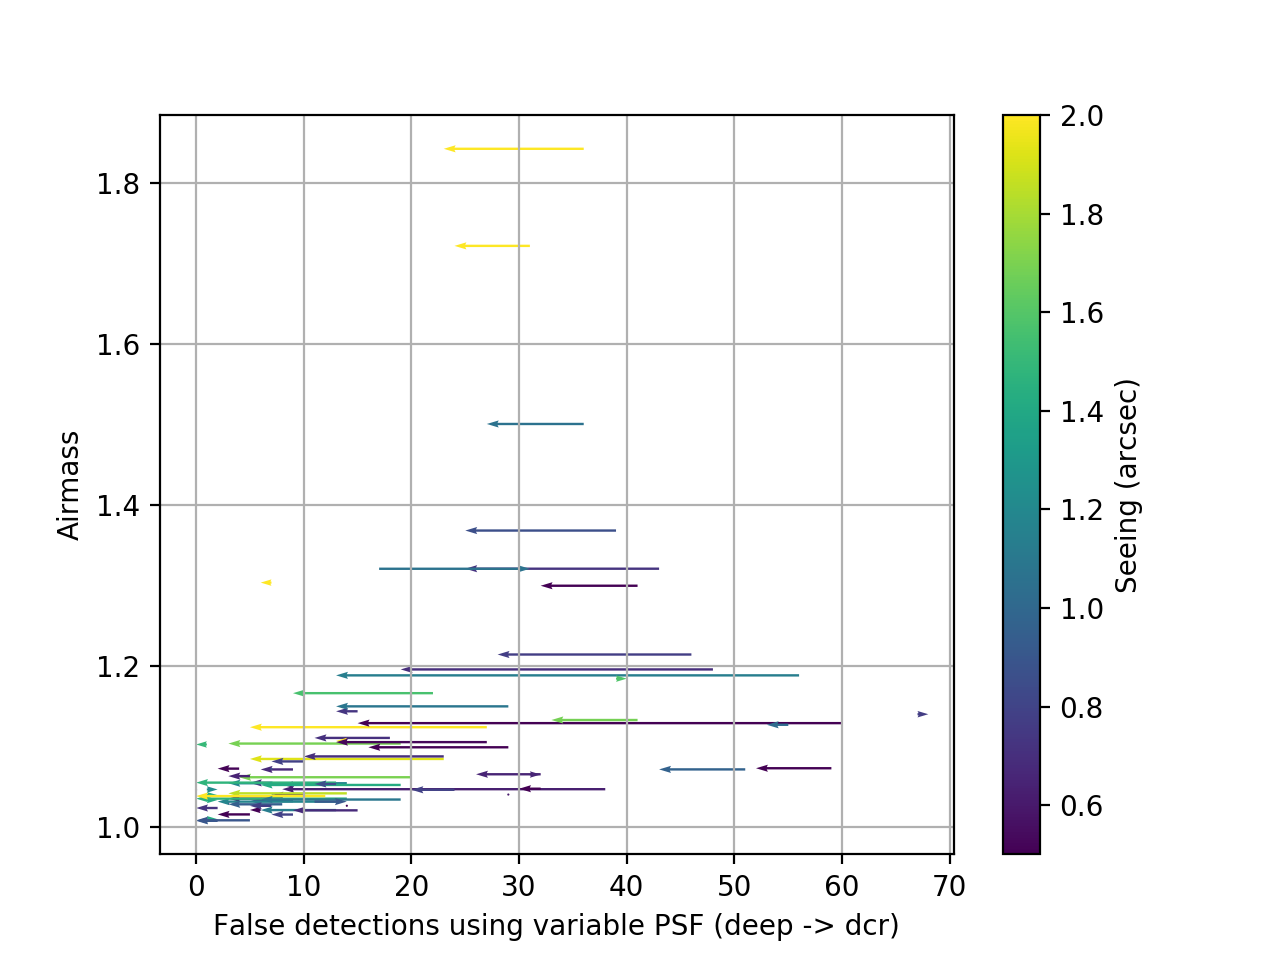

In [217]:
plot_diffim_quiver(var_alerts_deep, var_alerts_dcr, template=var_template_dcr,
                   psf_name='variable', window=4, width=3e-3, legend_location=1,
                   seeing_dict=seeing_dict)

Load the 2018 baseline survey

In [65]:
n_obs_list = [8, 8, 8]
repeat_obs = 3  # number of different fields with the given n_obs to generate simulations of
template_year = 1 
alert_year = 2
n_star = 10000
n_quasar = 1000

Connect to the database and set up for all of the simulations

Create a second set of simulations where the fields can be mosaiced together

In [66]:
airmass_threshold = 1.15  # Target fields must include at least one observation above this airmass to be included
opsim = OpSim_wrapper(year=template_year, filt='g', opsim_db='/Users/sullivan/LSST/OpSim/baseline2018a.db',
                      sim_directory="/Users/sullivan/LSST/simulations/OpSim/pontus_2568/",
                      conditions_db="/Users/sullivan/LSST/OpSim/pontus_2568.db",
                      airmass_threshold=airmass_threshold)

In [67]:
nx = repeat_obs
ny = len(n_obs_list)
n = nx if nx > ny else ny
simulation_size = n
dither_scale = 0.
dither_x = dither_scale*(np.arange(nx) - (nx - 1)/2)
dither_y = dither_scale*(np.arange(ny) - (ny - 1)/2)

In [68]:
initial_seeing_range = 1.
initial_var = True
seed = 42
randomize_conditions = True
randomize_template = True
n_alert = 24

Make a text file containing the visit list, and save the observing conditions

In [69]:
visits = None
mosaic = True
randomize_conditions = True
band_dict = {'u': 0, 'g': 1, 'r': 2, 'i': 3, 'z': 4, 'y': 5}
seeing_dict = {}
airmass_dict = {}
rng = np.random.RandomState(seed+3)
index = int(np.rint(rng.rand()*1000))
field_Id = 100
alert_field_Id = 0
seeing_range = initial_seeing_range
for d_y, n_obs in zip(dither_y, n_obs_list):
    for rpt in range(repeat_obs):
        d_x = dither_x[rpt]
        opsim.set_field(n_obs=4, index=index, year=template_year)
        field_Id0 = opsim.field_Id
        if randomize_template:
            opsim.update_year(template_year, randomize_conditions=randomize_conditions,
                              set_n_obs=n_obs, force_seeing_range=seeing_range)
        n_obs1 = len(opsim.airmass)
        for t_i in range(n_obs1):
            fieldId_i = 100*field_Id + 1000000*template_year + t_i
            seeing_dict[fieldId_i] = opsim.seeing[t_i]
            airmass_dict[fieldId_i] = opsim.airmass[t_i]
        
        opsim.field_Id = field_Id
        if mosaic:
            visit_name1 = "%i" % (100*opsim.field_Id + 1000000*template_year)
            visit_name1b = "%i" % (100*opsim.field_Id + 1000000*template_year + n_obs1 - 1)
        else:
            visit_name1 = "%i" % (100*band_dict[opsim.filter] + 1000*template_year)
            visit_name1b = "%i" % (100*band_dict[opsim.filter] + 1000*template_year + n_obs1 - 1)
        if visits is None:
            visits = visit_name1
        else:
            visits += "^" + visit_name1
        visits += "..%s" % visit_name1b
        field_Id += 1
        seeing_range *= 1.1

d_x = 0
d_y = 0
opsim.set_field(n_obs=4, index=index, year=alert_year)
if randomize_template:
    opsim.update_year(alert_year, randomize_conditions=randomize_conditions,
                      set_n_obs=n_alert)
n_obs1 = len(opsim.airmass)
for t_i in range(n_obs1):
    fieldId_i = 100*alert_field_Id + 1000000*alert_year + t_i
    seeing_dict[fieldId_i] = opsim.seeing[t_i]
    airmass_dict[fieldId_i] = opsim.airmass[t_i]
opsim.field_Id = alert_field_Id
if mosaic:
    visit_name2 = "%i" % (100*opsim.field_Id + 1000000*alert_year)
    visit_name2b = "%i" % (100*opsim.field_Id + 1000000*alert_year + n_obs1 - 1)
else:
    visit_name2 = "%i" % (100*band_dict[opsim.filter] + 1000*alert_year)
    visit_name2b = "%i" % (100*band_dict[opsim.filter] + 1000*alert_year + n_obs1 - 1)
visits += "^" + visit_name2
visits += "..%s" % visit_name2b

Selecting 13 obs from field 2575, with seeing range 0.622 to 0.999 and airmass range 1.123 to 1.190
Selecting 8 randomized obs from field 2575, with seeing range 0.524 to 0.524 and airmass range 1.012 to 1.484
Selecting 13 obs from field 2575, with seeing range 0.622 to 0.999 and airmass range 1.123 to 1.190
Selecting 8 randomized obs from field 2575, with seeing range 0.524 to 0.577 and airmass range 1.012 to 1.484
Selecting 13 obs from field 2575, with seeing range 0.622 to 0.999 and airmass range 1.123 to 1.190
Selecting 8 randomized obs from field 2575, with seeing range 0.524 to 0.635 and airmass range 1.012 to 1.484
Selecting 13 obs from field 2575, with seeing range 0.622 to 0.999 and airmass range 1.123 to 1.190
Selecting 8 randomized obs from field 2575, with seeing range 0.524 to 0.698 and airmass range 1.012 to 1.484
Selecting 13 obs from field 2575, with seeing range 0.622 to 0.999 and airmass range 1.123 to 1.190
Selecting 8 randomized obs from field 2575, with seeing rang

In [70]:
seeing_dict

{1010000: 0.5244374092174477,
 1010001: 0.5244374092174477,
 1010002: 0.5244374092174477,
 1010003: 0.5244374092174477,
 1010004: 0.5244374092174477,
 1010005: 0.5244374092174477,
 1010006: 0.5244374092174477,
 1010007: 0.5244374092174477,
 1010100: 0.5768811501391926,
 1010101: 0.5372874608334048,
 1010102: 0.5583353681225943,
 1010103: 0.5431252897328596,
 1010104: 0.5350322774828323,
 1010105: 0.566082489925671,
 1010106: 0.5244374092174477,
 1010107: 0.5577056444149199,
 1010200: 0.6345692651531118,
 1010201: 0.5514225176109577,
 1010202: 0.5956231229182556,
 1010203: 0.5636819582998125,
 1010204: 0.5466866325747554,
 1010205: 0.6118920787047166,
 1010206: 0.5244374092174477,
 1010207: 0.5943007031321392,
 1010300: 0.6980261916684232,
 1010301: 0.5669710800662658,
 1010302: 0.636639653193483,
 1010303: 0.5862942937234608,
 1010304: 0.5595064231758706,
 1010305: 0.6622826263616668,
 1010306: 0.5244374092174477,
 1010307: 0.6345552677210806,
 1010400: 0.7678288108352656,
 1010401: 0.